In [15]:
import os 
import shutil
import numpy as np 
import emcee 
import time
import pandas as pd
import matplotlib.pylab as plt 
import random
from cobaya.run import run
from utils.helpers import pickle_save, pickle_load

# NUTS
from numpyro.diagnostics import summary
import jax
import jax.numpy as jnp 
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_median
from numpyro.handlers import seed

os.makedirs('mvn', exist_ok=True)
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (8,6)
fontSize = 20

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]='.10'

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
dimensions = np.arange(1, 11, 1, dtype = int) * 10

EPS = 0.01
NWARMUP = 500 
TREEDEPTH = 6
NSAMPLES_NUTS = 5000
NSAMPLES_EMCEE = 2000
NSAMPLES_COBAYA = 200000 
OUTPUT_FOLDER = 'CobayaMVN/'

# Sample Multivariate Normal with EMCEE

In [4]:
def emcee_log_prob(position, mean, covariance):
    diff = position - mean
    return -0.5 * np.dot(diff, np.linalg.solve(covariance, diff))
    
def emcee_sampler(ndim, nsamples = 10000):
    mean = np.zeros(ndim)
    cov = np.eye(ndim)
    nwalkers = 2 * ndim 
    initial_1 = np.random.rand(nwalkers, ndim)
    initial_2 = np.random.rand(nwalkers, ndim)

    # we use two samplers (to compute the Gelman-Rubin statistics)
    sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_1 = sampler_1.run_mcmc(initial_1, nsamples, progress = True)

    sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_2 = sampler_2.run_mcmc(initial_2, nsamples, progress = True)

    return sampler_1, sampler_2, mean, cov

def process_emcee(sampler_1, sampler_2):
    samples_1 = sampler_1.flatchain
    samples_2 = sampler_2.flatchain 
    ndim = samples_1.shape[1]
    ap_1 = np.mean(sampler_1.acceptance_fraction)
    ap_2 = np.mean(sampler_2.acceptance_fraction)
    return samples_1, samples_2, ap_1, ap_2

def calculate_mean_cov(samples):
    """
    The input is of shape N x p, where N is the number of samples and p is the number of dimensions. 
    """
    sample_mean = np.mean(samples, axis = 0)
    sample_cov = np.cov(samples.T)
    return sample_mean, sample_cov

def calculate_summary(samples_1, samples_2, nlike, ndecimal = 3):
    
    print(f'Number of likelihood evaluations is : {nlike}')
    record = []
    for i in range(samples_1.shape[1]):
        x1 = samples_1[:,i]
        x2 = samples_2[:,i]
            
        testsamples = np.vstack(([x1, x2]))
        summary_stats = summary(testsamples)
        summary_stats[f'p_{i}'] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(ndecimal).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['scaled_n_eff'] = record_df['n_eff'] / nlike 
    return record_df
    
def compute_kl(mean0, mean1, cov0, cov1):
    cov1_inv = np.linalg.inv(cov1)
    ndim = cov1.shape[0]
    term1 = np.trace(cov1_inv @ cov0) - ndim 
    term2 = (mean1 - mean0) @ cov1_inv @ (mean1 - mean0)
    sign0, logdet0 = np.linalg.slogdet(cov0)
    sign1, logdet1 = np.linalg.slogdet(cov1)
    term3 = sign1 * logdet1 - sign0 * logdet0 
    return 0.5*(term1 + term2 + term3)

In [ ]:
# emcee_record_time = list()

# for d in dimensions:

#     # generate the samples 
#     start_time = time.time()
#     sampler_1, sampler_2, true_mean, true_cov = emcee_sampler(d, nsamples = NSAMPLES_EMCEE)    
#     time_taken = time.time() - start_time
#     emcee_record_time.append(time_taken)
    
#     # save the entire sampler
#     pickle_save(sampler_1, 'samples/mvn', f'sampler_emcee_mvn_1_{d}')
#     pickle_save(sampler_1, 'samples/mvn', f'sampler_emcee_mvn_2_{d}')

# NUTS

In [19]:
def nuts_model(ndim = 5):
    locs = jnp.zeros(ndim)
    covs = jnp.eye(ndim)
    mvn = dist.MultivariateNormal(loc = locs, covariance_matrix = covs)
    numpyro.sample('y', mvn)
    return locs, covs

In [6]:
%%capture
def run_nuts(dimension):
    
    nuts_kernel = NUTS(nuts_model, 
                       step_size=EPS, 
                       init_strategy=init_to_median, 
                       dense_mass=True, 
                       max_tree_depth=TREEDEPTH)

    mcmc = MCMC(nuts_kernel, 
                num_chains=2, 
                num_warmup = NWARMUP, 
                num_samples=NSAMPLES_NUTS, 
                chain_method="vectorized")
    
    mcmc.run(jax.random.PRNGKey(random.randint(0, 1000)), 
             ndim=dimension, 
             extra_fields=('potential_energy', 'num_steps'))
    return mcmc

In [ ]:
# nuts_record_time = list()

# for d in dimensions:
#     start_time = time.time()
#     mcmc = run_nuts(d)
#     time_taken = time.time() - start_time 
#     nuts_record_time.append(time_taken)
    
#     # save the sampler 
#     pickle_save(mcmc, 'samples/mvn', f'sampler_nuts_mvn_{d}')   

# Cobaya

In [8]:
def cobaya_mvn(ndim, number):
    
    position = {
            "prior": {"min": -5.0, "max": 5.0},
            "ref": {"dist": "norm", "loc": 0.0, "scale": 1},
            "proposal": EPS
             }
    
    likelihood = {
                    "gaussian_mixture": {
                    "means": np.zeros(ndim),
                    "covs": np.eye(ndim),
                    "derived": False}
                 }
    
    parameters = {f'p{i}': position for i in range(ndim)}
    
    info = {"likelihood" : likelihood}
    info["params"] = parameters
    info["sampler"] = {"mcmc": {"max_samples": NSAMPLES_COBAYA, "Rminus1_stop": 0.01}}
    
    path =  OUTPUT_FOLDER + f"experiment_{ndim}_{number}/"
    if os.path.exists(path) and os.path.isdir(path):
        shutil.rmtree(path)
    info["output"] = path + 'mvn'
    updated_info, sampler = run(info, )
    return sampler

def stats_cobaya(ndim):
    
    nsamples = []
    nevals = []
    record_samples = []
    for number in range(2):
        path =  OUTPUT_FOLDER + f"experiment_{ndim}_{number+1}/"
        samples = np.loadtxt(path + 'mvn.1.txt')
        nsamples.append(samples.shape[0])
        nevals.append(sum(samples[:,0]))
        record_samples.append(samples[:,2:-4])
    min_nsamples = min(nsamples)
    nevals_tot = int(sum(nevals))
    print(f'Number of likelihood evaluation is :{nevals_tot}')
    return calculate_summary(record_samples[0][-min_nsamples:], record_samples[1][-min_nsamples:], nevals_tot)

def run_cobaya(ndim):
    sampler_1 = cobaya_mvn(ndim, 1)
    sampler_2 = cobaya_mvn(ndim, 2)
    return sampler_1, sampler_2

def get_cobaya_samples(sampler_1, sampler_2, ndim):
    
    data_1 = sampler_1.samples()
    data_2 = sampler_2.samples()
    
    samples_1 = data_1.data[data_1.sampled_params].values
    samples_2 = data_2.data[data_2.sampled_params].values
    
    nevals = sum(data_1.data.weight.values) + sum(data_2.data.weight.values)
    
    nsamples = [samples_1.shape[0], samples_2.shape[0]]
    min_samples = min(nsamples)
    
    return samples_1[-min_samples:], samples_2[-min_samples:], nevals

In [ ]:
# cb_record_time = list()

# for d in dimensions:
#     start_time = time.time()
#     sampler_1, sampler_2 = run_cobaya(d)
#     time_taken = time.time() - start_time 
#     cb_record_time.append(time_taken)

# Compare Results

In [28]:
def cobaya_statistics(dimensions, folder = 'CobayaMVN'):
    
    cb_record_kl = list()
    cb_record_stats = list()
    cb_record_nevals = list()

    for d in dimensions:
        fname1 = os.path.join(folder, f'experiment_{d}_1/mvn.1.txt')
        fname2 = os.path.join(folder, f'experiment_{d}_2/mvn.1.txt')
        data_1 = np.loadtxt(fname1)
        data_2 = np.loadtxt(fname2)
        nevals = sum(data_1[:,0]) + sum(data_2[:,0])
        
        samples_1 = data_1[:,2:-4]
        samples_2 = data_2[:,2:-4]

        nsamples = [samples_1.shape[0], samples_2.shape[0]]
        min_samples = min(nsamples)

        # calculate sample mean and covariance 
        cb_mean, cb_cov = calculate_mean_cov(np.concatenate([samples_1, samples_2]))

        # calculate the KL divergence 
        cb_kl = compute_kl(cb_mean, np.zeros(d), cb_cov, np.eye(d))

        # record quantities 
        cb_record_stats.append(calculate_summary(samples_1[-min_samples:], samples_2[-min_samples:], nevals))
        cb_record_kl.append(cb_kl)
        cb_record_nevals.append(nevals)

        # print KL divergence 
        print(f'KL-divergence is {cb_kl:.4f}')
        
    return cb_record_kl, cb_record_stats, cb_record_nevals

def nuts_statistics(dimensions, folder = 'mvn/'):

    nuts_record_kl = list()
    nuts_record_stats = list()
    nuts_record_ap = list()
    nuts_record_nevals = list()

    for d in dimensions:
        mcmc = pickle_load(folder, f'sampler_nuts_mvn_{d}')
        samples = np.asarray(mcmc.get_samples()['y'])
        samples_grouped = np.asarray(mcmc.get_samples(group_by_chain=True)['y'])
        nsteps = mcmc.get_extra_fields(group_by_chain=True)['num_steps']
        nevaluations = jnp.sum(nsteps).item()

        # calculate sample mean and covariance 
        nuts_mean, nuts_cov = calculate_mean_cov(samples)

        # calculate the KL divergence 
        nuts_kl = compute_kl(nuts_mean, np.zeros(d), nuts_cov, np.eye(d))

        # record quantities 
        nuts_record_stats.append(calculate_summary(samples_grouped[0], samples_grouped[1], nevaluations))
        nuts_record_kl.append(nuts_kl)
        nuts_record_ap.append(mcmc.last_state.mean_accept_prob)
        nuts_record_nevals.append(nevaluations)

        # print KL divergence 
        print(f'KL-divergence is {nuts_kl:.4f}')
    
    return nuts_record_kl, nuts_record_stats, nuts_record_nevals

def emcee_statistics(dimensions, folder = 'mvn/'):
    
    emcee_record_stats = list()
    emcee_record_kl = list()
    emcee_record_ap = list()
    emcee_record_nevals = list()
    
    for d in dimensions:
        sampler_1 = pickle_load(folder, f'sampler_emcee_mvn_1_{d}')
        sampler_2 = pickle_load(folder, f'sampler_emcee_mvn_2_{d}')
    
        samples_1, samples_2, ap_1, ap_2  = process_emcee(sampler_1, sampler_2)

        # calculate sample mean and covariance
        sample_mean, sample_cov = calculate_mean_cov(np.vstack([samples_1, samples_2]))

        # calculate KL divergence
        true_mean = np.zeros(d)
        true_cov = np.eye(d)
        emcee_kl = compute_kl(sample_mean, true_mean, sample_cov, true_cov)

        # record quantities 
        nevals = 2 * samples_1.shape[0]
        emcee_record_stats.append(calculate_summary(samples_1, samples_2, nevals))
        emcee_record_kl.append(emcee_kl)
        emcee_record_ap.append([ap_1.item(), ap_2.item()])
        emcee_record_nevals.append(nevals)
        
        # print value of KL 
        print(f'KL-divergence is {emcee_kl:.4f}')
        
    return emcee_record_kl, emcee_record_stats, emcee_record_nevals

In [29]:
dimensions = np.arange(1, 11, 1)*10

In [30]:
cb_record_kl, cb_record_stats, cb_record_nevals = cobaya_statistics(dimensions)

Number of likelihood evaluations is : 159249.0
KL-divergence is 0.0486
Number of likelihood evaluations is : 838446.0
KL-divergence is 0.5243
Number of likelihood evaluations is : 404529.0
KL-divergence is 20.3313
Number of likelihood evaluations is : 404750.0
KL-divergence is 38.6475
Number of likelihood evaluations is : 404785.0
KL-divergence is 57.0763
Number of likelihood evaluations is : 404542.0
KL-divergence is 77.7137
Number of likelihood evaluations is : 404615.0
KL-divergence is 99.6505
Number of likelihood evaluations is : 404341.0
KL-divergence is 118.7777
Number of likelihood evaluations is : 404655.0
KL-divergence is 152.4051
Number of likelihood evaluations is : 404744.0
KL-divergence is 180.0447


In [20]:
nuts_record_kl, nuts_record_stats, nuts_record_nevals = nuts_statistics(dimensions)

Number of likelihood evaluations is : 66516
KL-divergence is 0.0053
Number of likelihood evaluations is : 69940
KL-divergence is 0.0234
Number of likelihood evaluations is : 73152
KL-divergence is 0.0405
Number of likelihood evaluations is : 96152
KL-divergence is 0.0767
Number of likelihood evaluations is : 119304
KL-divergence is 0.1144
Number of likelihood evaluations is : 137104
KL-divergence is 0.1536
Number of likelihood evaluations is : 143256
KL-divergence is 0.1935
Number of likelihood evaluations is : 171040
KL-divergence is 0.2527
Number of likelihood evaluations is : 251584
KL-divergence is 0.2626
Number of likelihood evaluations is : 551360
KL-divergence is 0.2979


In [25]:
emcee_record_kl, emcee_record_stats, emcee_record_nevals = emcee_statistics(dimensions)

Number of likelihood evaluations is : 80000
KL-divergence is 0.0582
Number of likelihood evaluations is : 160000
KL-divergence is 0.3295
Number of likelihood evaluations is : 240000
KL-divergence is 1.0510
Number of likelihood evaluations is : 320000
KL-divergence is 1.8969
Number of likelihood evaluations is : 400000
KL-divergence is 3.5253
Number of likelihood evaluations is : 480000
KL-divergence is 5.8438
Number of likelihood evaluations is : 560000
KL-divergence is 8.3418
Number of likelihood evaluations is : 640000
KL-divergence is 12.2119
Number of likelihood evaluations is : 720000
KL-divergence is 14.4594
Number of likelihood evaluations is : 800000
KL-divergence is 18.9599


In [31]:
def compare_stats(emcee_df, nuts_df, cb_df):
    nexperiments = len(emcee_df)
    record_rhat = {'emcee': list(), 'nuts': list(), 'cb': list()}
    record_neff = {'emcee': list(), 'nuts': list(), 'cb': list()}
    for i in range(nexperiments):
        emcee_mean_stats = emcee_df[i].mean(0)
        nuts_mean_stats = nuts_df[i].mean(0)
        cb_mean_stats = cb_df[i].mean(0)
        record_rhat['emcee'].append(emcee_mean_stats['r_hat'].item())
        record_neff['emcee'].append(emcee_mean_stats['scaled_n_eff'].item())
        
        record_rhat['nuts'].append(nuts_mean_stats['r_hat'].item())
        record_neff['nuts'].append(nuts_mean_stats['scaled_n_eff'].item())

        record_rhat['cb'].append(cb_mean_stats['r_hat'].item())
        record_neff['cb'].append(cb_mean_stats['scaled_n_eff'].item())
        
    return pd.DataFrame(record_rhat, index = dimensions), pd.DataFrame(record_neff, index = dimensions)

In [33]:
df_rhat, df_neff = compare_stats(emcee_record_stats, nuts_record_stats, cb_record_stats)

df_kl = pd.DataFrame(np.vstack([emcee_record_kl, nuts_record_kl, cb_record_kl]).T, 
                     columns = ['emcee', 'nuts', 'cb'], index=dimensions)

## Plots

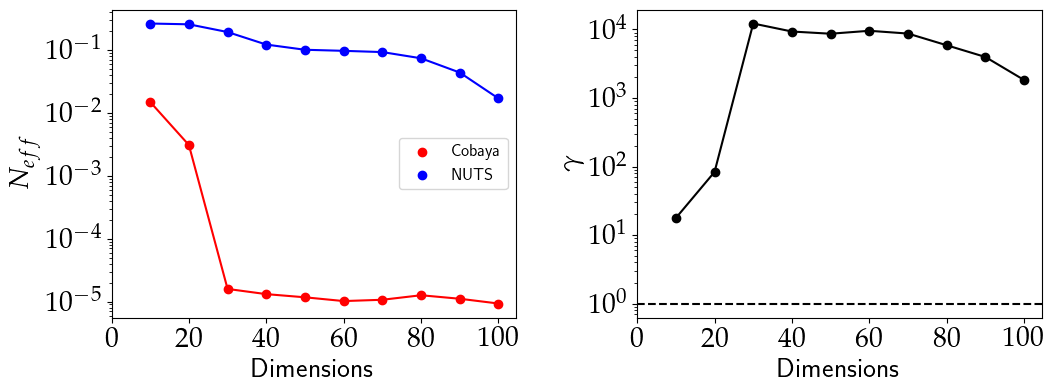

In [39]:
plt.figure(figsize = (12, 4))

plt.subplot(121)
plt.scatter(dimensions, df_neff['cb'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_neff['cb'], c = 'r')
plt.scatter(dimensions, df_neff['nuts'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_neff['nuts'], c = 'b')
plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
plt.yscale('log')

plt.subplot(122)
plt.scatter(dimensions, df_neff['nuts'] / df_neff['cb'], c = 'k')
plt.plot(dimensions, df_neff['nuts'] / df_neff['cb'], c = 'k')
plt.axhline(1.0, linestyle = '--', c = 'k')
plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$\gamma$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.yscale('log')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
# plt.savefig('/home/arrykrishna/Desktop/mvn_neff.pdf', bbox_inches = 'tight')
plt.show()

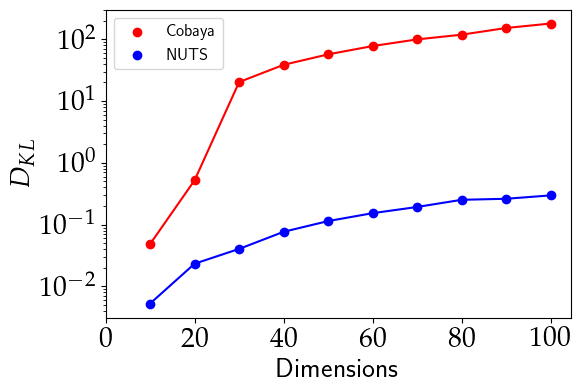

In [41]:
plt.figure(figsize = (6,4))
plt.scatter(dimensions, df_kl['cb'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_kl['cb'], c = 'r')
plt.scatter(dimensions, df_kl['nuts'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_kl['nuts'], c = 'b')
plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$D_{KL}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.yscale('log')
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
# plt.savefig('/home/arrykrishna/Desktop/mvn_dist.pdf', bbox_inches = 'tight')
plt.show()